# Imports

In [1]:
import os
import cv2
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import MultiLabelBinarizer

from cache import cache

In [2]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.python.keras.applications import VGG19
from tensorflow.python.keras.optimizers import Adam, RMSprop
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard

# Load Data

In [3]:
random.seed(2) # To always load the same images in each dataset split

In [4]:
def load_coco(input_path, split_train=0.8, split_val=0.19):
    """ Load coco dataset
        :params input_path: path to the parsed coco file
        :params split: split between training and validation dataset
    """
    with open(input_path, 'rb') as file:
        coco_raw = pickle.load(file)
    images_data = coco_raw['images_data']
    category_id = coco_raw['category_id']
    id_category = coco_raw['id_category']
    
    # split dataset
    img_ids = list(images_data.keys())
    split_idx_train = int(len(img_ids) * split_train)
    split_idx_val = int(len(img_ids) * split_val)
    random.shuffle(img_ids)
    img_ids_train = img_ids[:split_idx_train]
    img_ids_val = img_ids[split_idx_train:split_idx_train+split_idx_val]
    img_ids_test = img_ids[split_idx_train+split_idx_val:]
    
    # training dataset
    filenames_train = []
    categories_train = []
#     captions_train = []
    for img_id in img_ids_train:
        filenames_train.append(images_data[img_id]['file_name'])
        categories_train.append(images_data[img_id]['categories'])
#         captions_train.append(images_data[img_id]['captions'])
#     train_data = (filenames_train, categories_train, captions_train)
    train_data = (filenames_train, categories_train)
    
    # validation dataset
    filenames_val = []
    categories_val = []
    for img_id in img_ids_val:
        filenames_val.append(images_data[img_id]['file_name'])
        categories_val.append(images_data[img_id]['categories'])
    val_data = (filenames_val, categories_val)
    
    # test dataset
    filenames_test = []
    categories_test = []
    for img_id in img_ids_test:
        filenames_test.append(images_data[img_id]['file_name'])
        categories_test.append(images_data[img_id]['categories'])
    test_data = (filenames_test, categories_test)
    
    return train_data, val_data, test_data, category_id, id_category

In [5]:
train_data, val_data, test_data, category_id, id_category = load_coco('dataset/coco_raw.pickle')

(filenames_train, categories_train) = train_data
(filenames_val, categories_val) = val_data
(filenames_test, categories_test) = test_data

In [6]:
# Create the output as a multi-label vector

mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(categories_train)
y_val = mlb.fit_transform(categories_val)
y_test = mlb.fit_transform(categories_test)

In [7]:
# Folder containing the datset
data_dir = 'dataset'

In [8]:
num_classes = len(category_id)

In [9]:
num_images_train = len(filenames_train)
num_images_train

19324

### Helper functions to load and display images

In [10]:
def load_image(path, size=None, grayscale=False):
    """
    Load the image from the given file-path and resize it
    to the given size if not None.
    """

    # Load the image using opencv
    if not grayscale:  # BGR format
        image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    else:  # grayscale format
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    # Resize image if desired.
    if not size is None:
        image = cv2.resize(image, size)

    # Convert image to numpy array and scale pixels so they fall between 0.0 and 1.0
    image = np.array(image) / 255.0

    # Add 1 extra dimension to grayscale images
    if (len(image.shape) == 2):
        image = np.expand_dims(image, axis=-1)

    return image

In [13]:
def show_image(idx, train):
    """
    Load and plot an image from the training or validation set
    with the given index.
    """

    if train:
        # Use an image from the training-set
        filename = filenames_train[idx]
        categories = categories_train[idx]
    else:
        # Use an image from the validation-set
        filename = filenames_val[idx]
        categories = categories_val[idx]

    # Path for the image-file.
    path = os.path.join(data_dir, filename)

    # Print the captions for this image.
    for category in categories:
        print(category)
    
    # Load the image and plot it.
    img = load_image(path)
    plt.imshow(img)
    plt.show()

### Display a sample image

person
surfboard


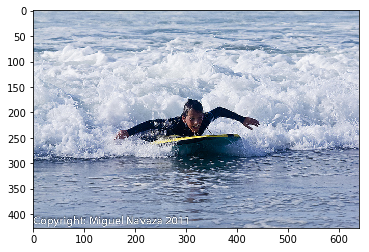

In [14]:
show_image(idx=1, train=True)

# Pre-Trained Image Model (VGG16)

In [15]:
# Download VGG16 model along with the fully-connected layers
model = VGG19(include_top=True, weights='imagenet')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [16]:
# Extract the second last layer which is a fully-connected layer
transfer_layer = model.get_layer('block5_pool')

In [17]:
transfer_layer.output

<tf.Tensor 'block5_pool/MaxPool:0' shape=(?, 7, 7, 512) dtype=float32>

In [18]:
# Create the encoder model
conv_model = Model(inputs=model.input, outputs=transfer_layer.output)

In [19]:
# Start a new Keras Sequential model.
image_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
image_model.add(conv_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
image_model.add(Flatten())

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
image_model.add(Dense(1024, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
image_model.add(Dropout(0.5))

# Add the final layer for the actual classification.
image_model.add(Dense(num_classes, activation='sigmoid'))

In [20]:
optimizer = Adam(lr=1e-3)

In [21]:
loss = 'categorical_crossentropy'

In [22]:
metrics = ['categorical_accuracy']

In [23]:
def print_layer_trainable():
    for layer in conv_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

In [24]:
print_layer_trainable()

True:	input_1
True:	block1_conv1
True:	block1_conv2
True:	block1_pool
True:	block2_conv1
True:	block2_conv2
True:	block2_pool
True:	block3_conv1
True:	block3_conv2
True:	block3_conv3
True:	block3_conv4
True:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_conv4
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_conv4
True:	block5_pool


In [25]:
conv_model.trainable = False
for layer in conv_model.layers:
    layer.trainable = False

print_layer_trainable()

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_conv4
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_conv4
False:	block4_pool
False:	block5_conv1
False:	block5_conv2
False:	block5_conv3
False:	block5_conv4
False:	block5_pool


In [26]:
image_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)